In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from utils import PlotLearning, plot_count, plot_confusion_matrix, plot_image_example



# 1. Preparation

## 1.1 Download the data

In [2]:
!kaggle competitions download -c digit-recognizer -p input/

100%|██████████████████████████████████████| 15.3M/15.3M [00:09<00:00, 2.02MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:09<00:00, 1.67MB/s]


In [3]:
import zipfile

# Specify the path to the zip file you want to unzip
zip_file_path = 'input/digit-recognizer.zip'

# Specify the directory where you want to extract the contents
extracted_dir = 'input/'
os.makedirs(extracted_dir, exist_ok = True)
# Open the zip file for reading
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extracted_dir)


## 1.2 Load data

/Users/ipurwadi/miniforge3/envs/weipa_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


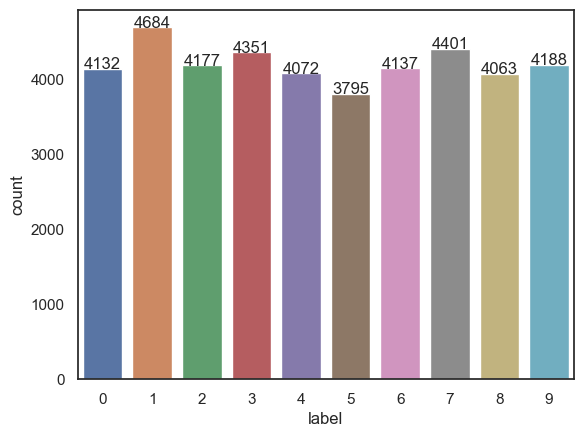

In [4]:
# Load the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 


plot_count(Y_train)

## 1.3 Normalization

In [5]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 1.4 Reshape

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 1.5 Label encoding

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## 1.6 Split training and valdiation set 

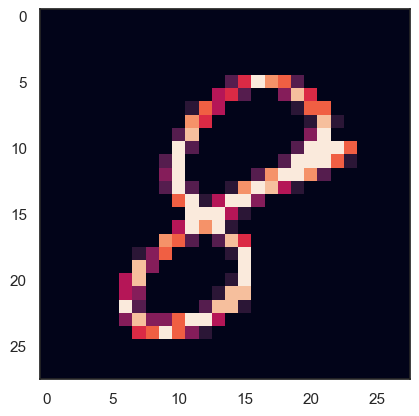

In [8]:
# Split the train and the validation set for the fitting
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

# Some examples
plot_image_example(X_train[0][:,:,0])

# 2 Training
## 2.1 Define the model

In [9]:
def conv_2d(filter_size: int, kernel_size: tuple):
    """
    Create a 2D convolutional layer.
    Args:
        filter_size (int): The number of filters (output channels) in the convolutional layer.
        kernel_size (tuple): The size of the convolutional kernel as a tuple of integers (e.g., (3, 3)).

    Returns:
        tensorflow.keras.layers.Conv2D: A 2D convolutional layer with the specified parameters.
    """
    return Conv2D(filters=filter_size, kernel_size=kernel_size, padding='Same', activation='relu')
    
model = Sequential()


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(conv_2d(filter_size = 32, kernel_size = (5,5)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(conv_2d(filter_size = 64, kernel_size = (3,3)))
model.add(conv_2d(filter_size = 64, kernel_size = (3,3)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-09-02 21:05:58.926456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-02 21:05:58.926601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 2.2 Optimizer and Callback function

In [10]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/Users/ipurwadi/miniforge3/envs/weipa_tf/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [12]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [13]:
from keras.callbacks import EarlyStopping
# early stopping activated if the validation loss does not improve for three consecutive epochs (patience set to 3).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
from keras.callbacks import ModelCheckpoint
# to save the model's best weights during training to the 'output/best_model.hdf5' file when the validation loss reaches its minimum value, 
# with verbosity for progress reporting and 'min' mode for monitoring loss reduction.
output_folder = 'output'
os.makedirs(output_folder, exist_ok = True)

saved_best_model = ModelCheckpoint(filepath=os.path.join(output_folder, 'best_model.hdf5'), 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

## 2.3 Data augmentation and model training

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [16]:
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

logs {'loss': 0.0204121395945549, 'accuracy': 0.9937158226966858, 'val_loss': 0.014983645640313625, 'val_accuracy': 0.9954761862754822, 'lr': 6.25e-05}


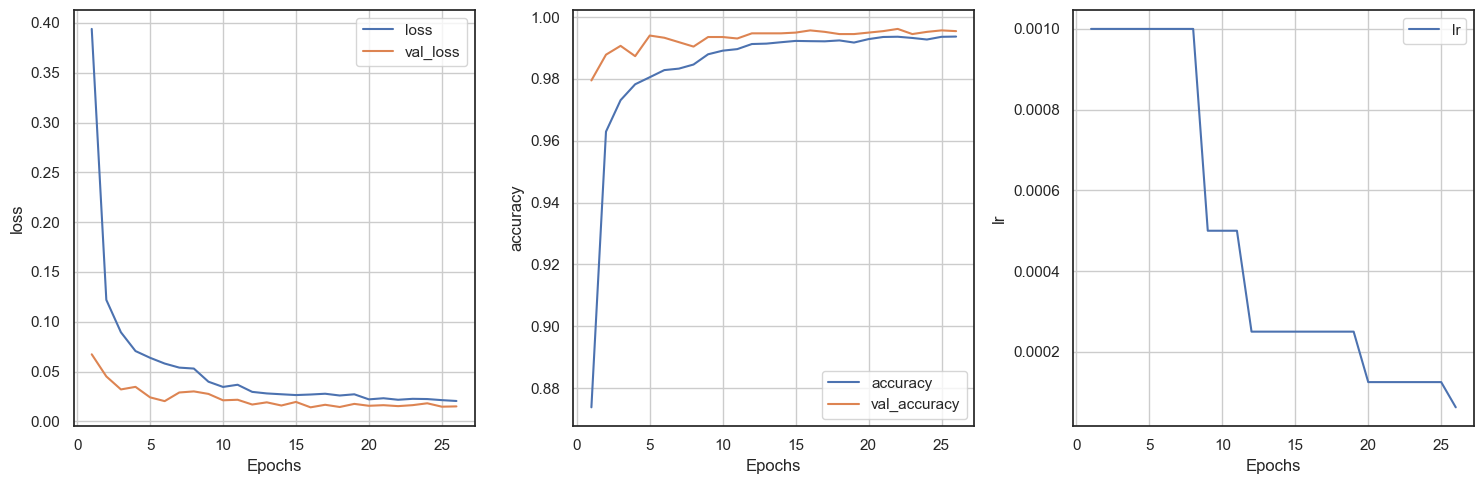


Epoch 26: val_loss did not improve from 0.01404
439/439 - 9s - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0150 - val_accuracy: 0.9955 - lr: 6.2500e-05 - 9s/epoch - 21ms/step


In [17]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, PlotLearning(), early_stopping, saved_best_model ])

# 3. Evaluate the model

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

2023-09-02 21:22:37.072604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


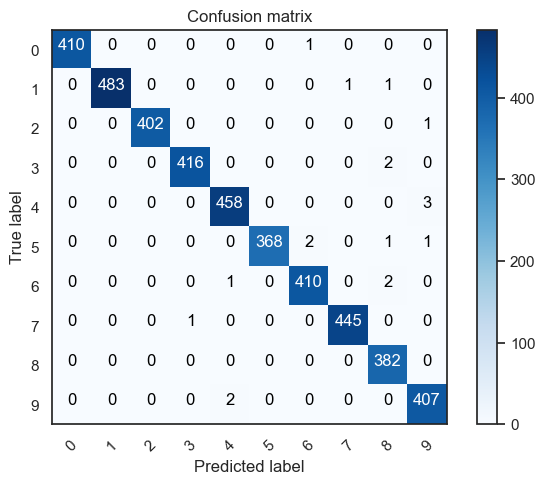

In [18]:
# Look at confusion matrix 



# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 